In [40]:
import os
import numpy as np
import pandas as pd
from ExKMC.Tree import Tree as ExTree
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
from intercluster import *
from intercluster.rules import *
from intercluster.pruning import *
from intercluster.experiments import *

from sklearn.metrics import adjusted_rand_score, accuracy_score

# Helps with KMeans memory leak issues.
os.environ["OMP_NUM_THREADS"] = "1"

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
# This assumes tex is installed in your system, 
# if not you may simply remove most of this, aside from font.size:
 
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "font.family": "serif",
    "font.serif": [],
    "text.usetex": True,
    "pgf.rcfonts": False,
    "font.size": 20
})

palette = sns.color_palette("husl", 8)
cmap = ListedColormap(palette)

subset_colors = [cmap(0), cmap(1), cmap(3), cmap(4), cmap(5), cmap(6)]
cmap_subset = ListedColormap(subset_colors)

uncovered_color = (1,1,1)
overlap_color = (0.45, 0.5, 0.5)

### Load Data

In [50]:
# Read and process data:
data, data_label_array, feature_labels, scaler = load_preprocessed_anuran('../data/anuran')

'''
import math
size = math.ceil(0.25 * len(data))
random_samples = np.sort(np.random.choice(len(data), size = size, replace = False))
data = data[random_samples, :]
data_label_array = data_label_array[random_samples]
data_labels = labels_format(data_label_array)
'''


# Parameters:
n = data.shape[0]
d = data.shape[1]
k = 10

### KMeans

In [51]:
samples = 10
num_clusters_trials = np.array(list(range(2,20)))
num_clusters_costs = np.zeros((len(num_clusters_trials), samples))

for i, nclusters in enumerate(num_clusters_trials):
    for j in range(samples):
        kmeans = KMeans(n_clusters=nclusters, n_init="auto", random_state = None).fit(data)
        kmeans_labels = labels_format(kmeans.labels_)
        kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = nclusters)
        cost = kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment)
        num_clusters_costs[i,j] = cost

Text(0.5, 0, 'Number of clusters')

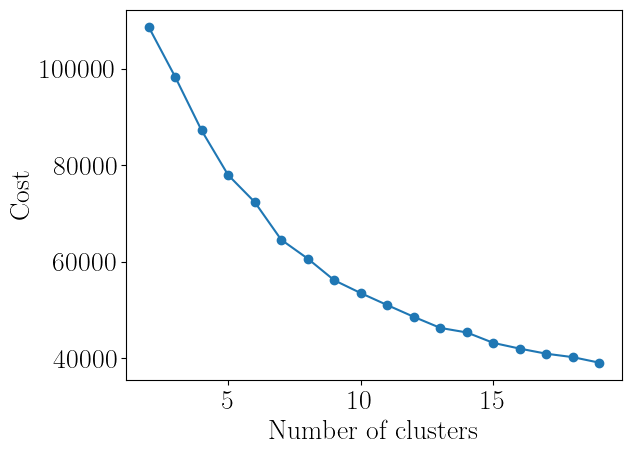

In [52]:
plt.plot(num_clusters_trials, np.mean(num_clusters_costs, axis = 1), marker = 'o')
plt.ylabel('Cost')
plt.xlabel('Number of clusters')

In [53]:
np.random.seed(342)
kmeans = KMeans(n_clusters=k, n_init="auto", random_state = None).fit(data)
kmeans_labels = labels_format(kmeans.labels_)
kmeans_assignment = labels_to_assignment(kmeans_labels, n_labels = k)
kmeans_cost(data, kmeans.cluster_centers_, kmeans_assignment, average = True, normalize = True)

7.2516713330413305

In [55]:
#adjusted_rand_score(data_label_array, flatten_labels(kmeans_labels))

### IMM

In [56]:
exkmc_tree = ExkmcTree(
    k = k,
    kmeans = kmeans,
    max_leaf_nodes = k,
    imm = True
)
exkmc_tree.fit(data)
exkmc_labels = exkmc_tree.predict(data, leaf_labels = False)
exkmc_assignment = labels_to_assignment(exkmc_labels, n_labels = k)
exkmc_centers = update_centers(data, kmeans.cluster_centers_, exkmc_assignment)
imm_depth = exkmc_tree.depth
kmeans_cost(data, exkmc_centers, exkmc_assignment, average = True, normalize = True)

8.73185465787021

### SVM

In [57]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import RFE

cselect = 0
y = (kmeans.labels_ == cselect).astype(int)
svm = LinearSVC(C = 100)
#svm.fit(data, y)
#svm_labels = svm.predict(data)

selector = RFE(svm, n_features_to_select=2, step=100)
selector = selector.fit(data, y)
selected_features = selector.support_

X_select = data[:, selected_features]
svm.fit(X_select, y)
svm_labels = svm.predict(X_select)

In [58]:
accuracy_score(y, svm_labels)

0.9457956914523975

### Decision Forest

In [59]:
np.random.seed(342)

In [71]:
# Module Parameters:
n_clusters = k
n_rules = k
frac_cover = 0.9
n_trees = 500
n_sets = 500
data_labels = kmeans_labels
centers = kmeans.cluster_centers_


# Depth 2 Forest:
forest_tree_params_depth_2 = {
    'max_depth' : 2
}

forest_params_depth_2 = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_2,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : [1,2],
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# Depth IMM Forest:
forest_tree_params_depth_imm = {
    'max_depth' : imm_depth
}

forest_params_depth_imm = {
    'tree_model' : SklearnTree,
    'tree_params' : forest_tree_params_depth_imm,
    'num_trees' : n_trees,
    'max_features' : d,
    'max_labels' : 1,
    'max_depths' : list(range(1, imm_depth + 1)),
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75
}

# SVM set:
svm_params = {
    'num_rules' : n_sets,
    'num_features' : 2,
    'feature_pairings' : [list(range(d))],
    'train_size' : 0.75,
    'svc_params' : {'C' : 1},
    'step_size' : 1
}

In [72]:
forest = DecisionForest(**forest_params_depth_2)
forest.fit(data, kmeans_labels)

In [73]:
forest_depth_imm = DecisionForest(**forest_params_depth_imm)
forest_depth_imm.fit(data, kmeans_labels)

In [74]:
svm_set = SVMSet(**svm_params)
svm_set.fit(data, kmeans_labels)

### Pruning

In [64]:
model = forest
search_range = np.linspace(0,5,101)

data_to_rules_assignment = model.get_data_to_rules_assignment(data)
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)
selected_rules, objective_vals, coverage_vals = prune_with_grid_search(
    n_rules = n_rules,
    frac_cover = 0, # Just using 0 required coverage for now to be able to see the full picture.
    n_clusters = n_clusters,
    data_labels = data_labels,
    rule_labels = model.decision_set_labels,
    data_to_rules_assignment = data_to_rules_assignment,
    objective = prune_objective,
    lambda_search_range = search_range,
    cpu_count = 4,
    return_full = True
)

Text(0, 0.5, 'Cost')

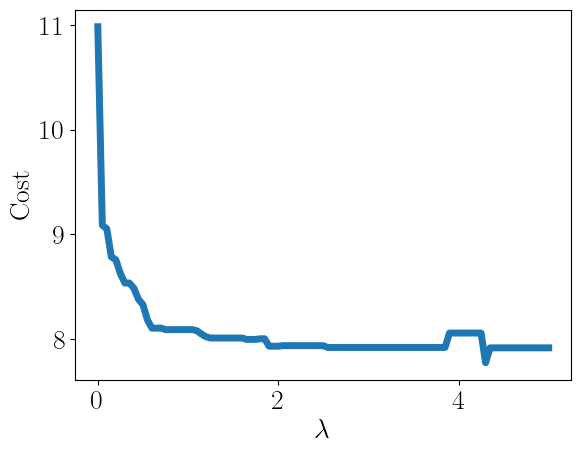

In [75]:
plt.plot(search_range, objective_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Cost")

Text(0, 0.5, 'Coverage')

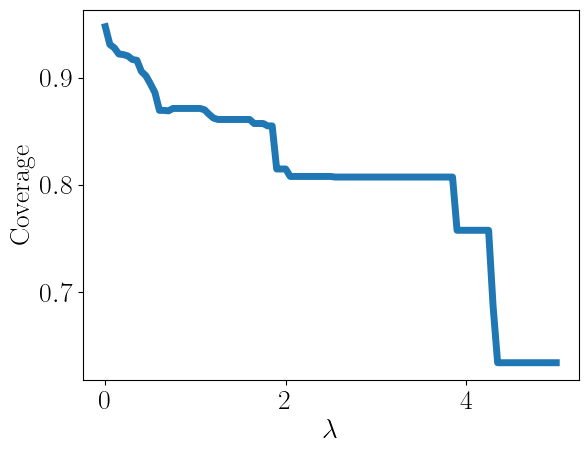

In [76]:
plt.plot(search_range, coverage_vals, linewidth = 5)
plt.xlabel(r"$\lambda$")
plt.ylabel("Coverage")

In [77]:
prune_objective = KmeansObjective(
    X = data,
    centers = centers,
    average = True,
    normalize = True
)

prune_params = {
    'n_rules' : n_rules,
    'frac_cover' : 0.8,
    'n_clusters' : n_clusters,
    'X' : data,
    'y' : data_labels,
    'objective' : prune_objective,
    'lambda_search_range' : np.linspace(0,5,101),
    'full_search' : False,
    'cpu_count' : 1
}

In [78]:
forest.prune(**prune_params)
forest_prune_predictions = forest.pruned_predict(data, rule_labels = False)

In [79]:
forest_depth_imm.prune(**prune_params)
forest_depth_imm_prune_predictions = forest_depth_imm.pruned_predict(data, rule_labels = False)

In [80]:
svm_set.prune(**prune_params)
svm_set_prune_predictions = svm_set.pruned_predict(data, rule_labels = False)

### Coverage Distributions

In [85]:
prune_predictions = svm_set_prune_predictions
assignment = labels_to_assignment(
    prune_predictions,
    n_labels = n_clusters
)
distance_ratios = distance_ratio(data, centers)

# Single Covers:
single_cover_mask = np.sum(assignment, axis = 1) == 1
single_cover_distance_ratios = distance_ratios[single_cover_mask]

# Overlaps:
overlap_mask = np.sum(assignment, axis = 1) > 1
overlap_distance_ratios = distance_ratios[overlap_mask]

# Uncovereds:
uncovered_mask = np.sum(assignment, axis = 1) < 1
uncovered_distance_ratios = distance_ratios[uncovered_mask]

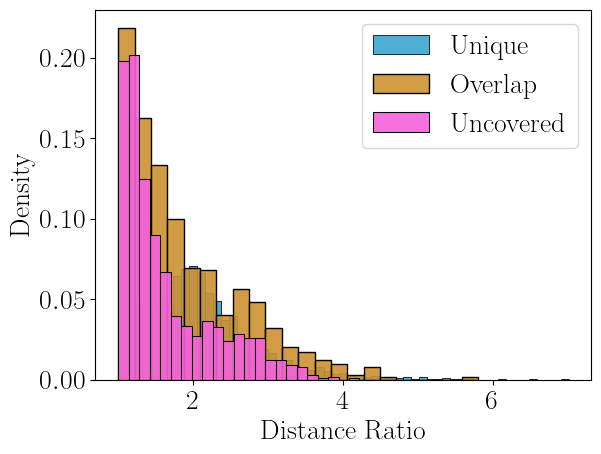

In [86]:
sns.histplot(single_cover_distance_ratios, stat = 'probability', alpha = 0.9, label = "Unique", color = cmap(5))
sns.histplot(overlap_distance_ratios, stat = 'probability', alpha = 0.9, label = "Overlap", color = cmap(1))
sns.histplot(uncovered_distance_ratios, stat = 'probability', alpha = 0.9, label = "Uncovered", color = cmap(7))
plt.ylabel("Density")
plt.xlabel("Distance Ratio")
plt.legend()
plt.savefig('../figures/anuran/svm_cover_dist.png', bbox_inches = 'tight', dpi = 300)